In [1]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import tensorflow
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, zero_one_loss, balanced_accuracy_score, average_precision_score

In [2]:
def calcular_error(y_test, y_pred):
    
    ## MEAN ABSOLUTE ERROR
    mae = MAE(y_test.flatten(), y_pred.flatten())

    ##MEAN SQUARE ERROR
    mse = MSE(y_test.flatten(), y_pred.flatten())

    ## root mean square error
    rmse = np.sqrt(mse)

    return mae, mse, rmse

In [3]:
def cargar_dataset(path_x, path_y):
    # carga dataset x_test e y_test
    Y_test = np.load(path_y)
    X_test = np.load(path_x)
        
    # Recorte para obtener 128x144
    X_test = X_test[:, :, 0:128, 0:144]
    Y_test = Y_test[:, 0:128, 0:144]
    Y_test = np.expand_dims(Y_test, axis=1)
    
    # Muevo el eje RGB al ultimo
    X_test = np.moveaxis(X_test, 1, 3)
    Y_test = np.moveaxis(Y_test, 1, 3)
    
    return X_test, Y_test

### opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) / loss=mae
### HGT = 400-800-1000 mb / 100 epochs SHUFFLE

In [4]:
path_x = "/opt/datos/dataset/gfs/hgt_shuffle/X_test_3-7-9.npy"
path_y = "/opt/datos/dataset/gfs/hgt_shuffle/Y_test.npy"

X_test, Y_test = cargar_dataset(path_x, path_y) 
model = load_model("/opt/datos/entrenamientos/gfs/09.h5")
y_pred = model.predict(X_test) #Unet

mae0, mse0, rmse0 = calcular_error(Y_test, y_pred)
print(f'MAE: {mae0}')
print(f'MSE: {mse0}')
print(f'RMSE: {rmse0}')

MAE: 0.20399128788852255
MSE: 0.6758685578168695
RMSE: 0.8221122537809964


In [7]:
def cargar_dataset2(path_y2):

    Y2 = np.load(path_y2)
    Y_next2 = np.zeros((19287, 137, 157))

    # Obtenemos lluvias en tiempo t + 1 
    for i in range(Y_next2.shape[0]):
        Y_next2[i] = Y2[i+1]
    Y2 = None

    Y_test2 =  Y_next2[16395:, :, :]
    Y_next2 = None
        
    # Recorte para obtener 128x144
    Y_test2 = Y_test2[:, 0:128, 0:144]
    Y_test2 = np.expand_dims(Y_test2, axis=1)
    
    # Muevo el eje RGB al ultimo
    Y_test2 = np.moveaxis(Y_test2, 1, 3)
    
    return Y_test2

path_y2 =  "/opt/datos/dataset/gfs/Y.npy"
Y_test2 = cargar_dataset2(path_y2) 

In [25]:
np.equal(Y_test[5,:,:,0], Y_test2[4,:,:,0])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

## Comparacion Errores

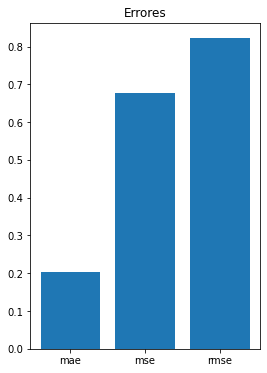

In [5]:
array_errores = {'mae':mae0, 'mse':mse0, 'rmse':rmse0}

plt.figure(figsize=(14,6))
plt.subplot(131), plt.bar(array_errores.keys(), array_errores.values()), plt.title('Errores')
plt.show()

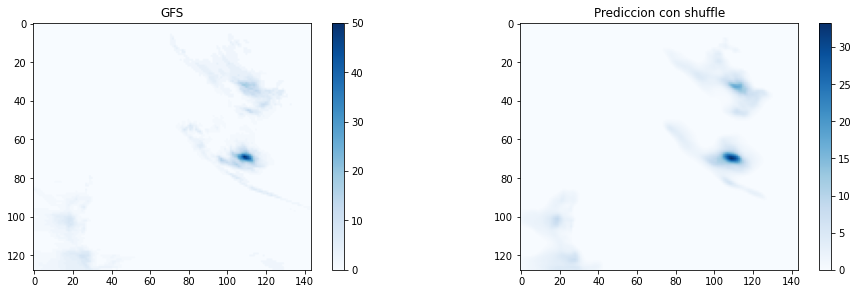

In [26]:
n = 265
plt.figure(figsize=(16,10))
plt.subplot(221), plt.imshow(Y_test[n], cmap='Blues'), plt.colorbar(), plt.title('GFS')
plt.subplot(222), plt.imshow(y_pred[n], cmap='Blues'), plt.colorbar(), plt.title('Prediccion con shuffle')
plt.show()

## Errores con clases

In [27]:
def to_clases(xy):
    xy_clases = np.copy(xy)
    xy_clases = xy_clases.astype('uint8')
    
    xy_clases[(xy_clases >= 0) & (xy_clases < 2)] = 0
    xy_clases[(xy_clases >= 2) & (xy_clases < 10)] = 1
    xy_clases[(xy_clases >= 10) & (xy_clases < 20)] = 2
    xy_clases[(xy_clases >= 20) & (xy_clases < 30)] = 3
    xy_clases[(xy_clases >= 30)] = 4
    
    return xy_clases;

In [28]:
def mostrar_resultados(y_t_flat, y_p_flat):
    predije = ["0", "1", "2", "3", "4"]
    conf_matrix = confusion_matrix(y_t_flat, y_p_flat)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=predije, yticklabels=predije, annot=True, fmt="d", norm=LogNorm());
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_t_flat, y_p_flat))

### 400-800-1000mb con shuffle

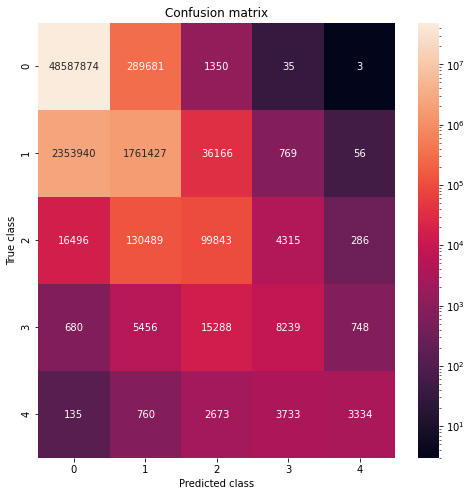

              precision    recall  f1-score   support

           0       0.95      0.99      0.97  48878943
           1       0.81      0.42      0.56   4152358
           2       0.64      0.40      0.49    251429
           3       0.48      0.27      0.35     30411
           4       0.75      0.31      0.44     10635

    accuracy                           0.95  53323776
   macro avg       0.73      0.48      0.56  53323776
weighted avg       0.94      0.95      0.94  53323776



In [30]:
y_test_clases = to_clases(Y_test)
y_test_flat = y_test_clases.flatten()

y_pred_clases = to_clases(y_pred)
y_pred_flat = y_pred_clases.flatten()

mostrar_resultados(y_test_flat, y_pred_flat)

### Comparación de imagenes clasificadas en clases.

In [32]:
a = to_clases(y_pred)
b = to_clases(Y_test)

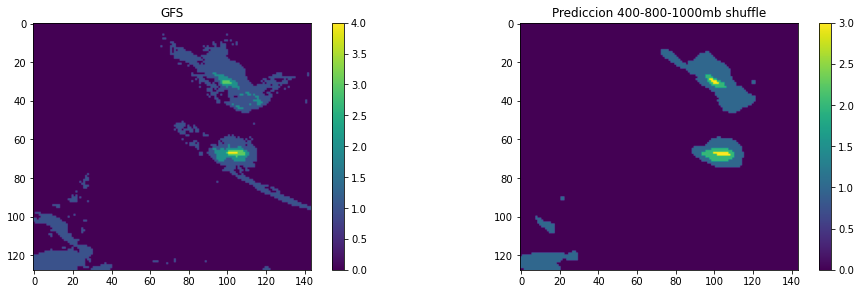

In [33]:
n = 264
plt.figure(figsize=(16,10))
plt.subplot(221), plt.imshow(b[n]), plt.colorbar(), plt.title('GFS')
plt.subplot(222), plt.imshow(a[n]), plt.colorbar(), plt.title('Prediccion 400-800-1000mb shuffle')
plt.show()

## Comparacion pixel a pixel

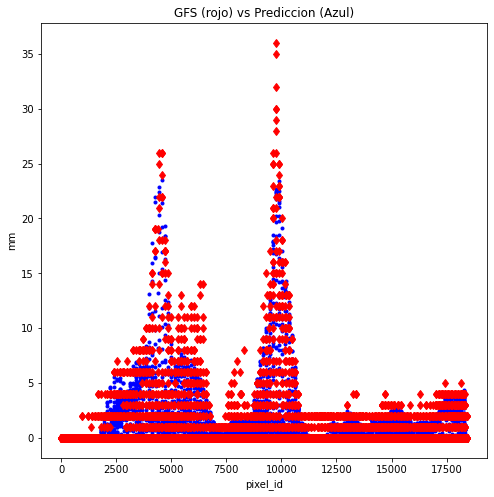

In [35]:
n=y_pred[0,:,:,0].flatten().shape[0]
i=264

plt.figure(figsize=(8,8))
plt.plot(range(n), y_pred[i,:,:,0].flatten(),'b.',range(n),Y_test[i,:,:,0].flatten(),'rd'), plt.title('GFS (rojo) vs Prediccion (Azul)')
plt.ylabel('mm')
plt.xlabel('pixel_id')
plt.show()
#y_pred_s[0,:,:,0].flatten().shape

### Comparación GFS vs PREDICCIÓN

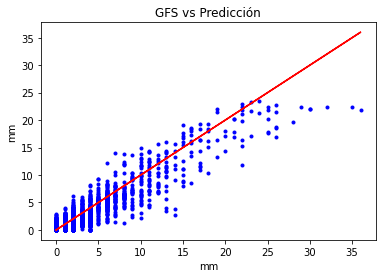

In [36]:
n=y_pred[0,:,:,0].flatten().shape[0]
i=264

plt.title('GFS vs Predicción')
plt.plot(Y_test[i,:,:,0].flatten(), y_pred[i,:,:,0].flatten() ,'b.',Y_test[i,:,:,0].flatten(),Y_test[i,:,:,0].flatten(),'r')
plt.ylabel('mm')
plt.xlabel('mm')
plt.show()